# Implementing and Testing snippets for Streamlit App
## Imports

In [36]:
import re
import importlib
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris, load_wine
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier \
    # HistGradientBoostingClassifier, AdaBoostClassifier
# from sklearn.linear_model import RidgeClassifier, LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay

import multiclass_proba_contour as mpc
importlib.reload(mpc)

<module 'multiclass_proba_contour' from 'c:\\Users\\Semyon\\Documents\\Python\\20_Projects\\mpc_clone\\multiclass-proba-contour_new\\multiclass_proba_contour.py'>

In [9]:
data = load_wine(as_frame=True)

## Datasets
User ought to be given three options:
1.  Pick one of the available toy data sets
2.  Generate synthetic data set
3.  Upload their own (must be preprocessed)

Upon data set selection/upload, user ought to be able to chose two features to be used for model training and plotting. Features must be numeric, (perferably) continuous variables.
### Toy Datasets
The easiest option. The available classification sets are nice and tidy.

In [10]:
target_names_map = {
    k:v for k, v in zip(
        range(len(data["target"].unique())), data["target_names"]
        )
    }
data["target"] = data["target"].map(target_names_map)

## Classifier Models
Got to generalise it: as an option, can explore ALL sklearn classifiers, find an intersection of all keyword arguments and define custom widgets for each keyword argument.

Upon data set and model selection, `ProbaVis` instance should be created. Data set, model and ProbaVis ought to be cashed to prevent unnesessary reruns.

In [11]:
isinstance(RandomForestClassifier(), RandomForestClassifier)

True

In [12]:
# bool(RandomForestClassifier())  # AttributeError

Parse the classifier documentation to obtain its and parameter description.

In [13]:
RandomForestClassifier().__doc__.split("\n\n")[:6]

['\n    A random forest classifier.',
 '    A random forest is a meta estimator that fits a number of decision tree\n    classifiers on various sub-samples of the dataset and uses averaging to\n    improve the predictive accuracy and control over-fitting.\n    The sub-sample size is controlled with the `max_samples` parameter if\n    `bootstrap=True` (default), otherwise the whole dataset is used to build\n    each tree.',
 '    Read more in the :ref:`User Guide <forest>`.',
 '    Parameters\n    ----------\n    n_estimators : int, default=100\n        The number of trees in the forest.',
 '        .. versionchanged:: 0.22\n           The default value of ``n_estimators`` changed from 10 to 100\n           in 0.22.',
 '    criterion : {"gini", "entropy", "log_loss"}, default="gini"\n        The function to measure the quality of a split. Supported criteria are\n        "gini" for the Gini impurity and "log_loss" and "entropy" both for the\n        Shannon information gain, see :ref:`tr

In [14]:
# include parameter names in pattern
model = RandomForestClassifier()
params = [p for p in model.get_params().keys()]
params_pattern = [p + " : " for p in params]
params_pattern = "|".join(params_pattern)
re.findall(params_pattern, model.__doc__)

['n_estimators : ',
 'criterion : ',
 'max_depth : ',
 'min_samples_split : ',
 'min_samples_leaf : ',
 'min_weight_fraction_leaf : ',
 'max_features : ',
 'max_leaf_nodes : ',
 'min_impurity_decrease : ',
 'bootstrap : ',
 'oob_score : ',
 'n_jobs : ',
 'random_state : ',
 'verbose : ',
 'warm_start : ',
 'class_weight : ',
 'ccp_alpha : ',
 'max_samples : ']

In [15]:
# split __doc__ with the pattern, remove the first piece and clean last one
params_desc = re.split(params_pattern, model.__doc__)[1:]
params_desc[-1] = params_desc[-1].split("Attributes\n")[0]
params_desc = {k:"\n".join(v.split("\n\n")) for k, v in zip(params, params_desc)}
params_desc

{'bootstrap': 'int, default=100\n        The number of trees in the forest.\n        .. versionchanged:: 0.22\n           The default value of ``n_estimators`` changed from 10 to 100\n           in 0.22.\n    ',
 'ccp_alpha': '{"gini", "entropy", "log_loss"}, default="gini"\n        The function to measure the quality of a split. Supported criteria are\n        "gini" for the Gini impurity and "log_loss" and "entropy" both for the\n        Shannon information gain, see :ref:`tree_mathematical_formulation`.\n        Note: This parameter is tree-specific.\n    ',
 'class_weight': 'int, default=None\n        The maximum depth of the tree. If None, then nodes are expanded until\n        all leaves are pure or until all leaves contain less than\n        min_samples_split samples.\n    ',
 'criterion': 'int or float, default=2\n        The minimum number of samples required to split an internal node:\n        - If int, then consider `min_samples_split` as the minimum number.\n        - If fl

In [16]:
print((len(params_desc.keys())))
print(len(set(model.get_params().keys())))
# set(params_desc.keys()).symmetric_difference(set(model.get_params().keys()))

18
18


In [17]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [18]:
[k for k,v in GradientBoostingClassifier().get_params().items() if v is None]

['init', 'max_features', 'max_leaf_nodes', 'n_iter_no_change', 'random_state']

**ChatGPT prompt**<br>
Could you please prepare streamlit widgets for the GradientBoostingClassifier parameters covering 'ccp_alpha', 'criterion', 'learning_rate', 'max_depth', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'subsample', 'tol', 'validation_fraction'? Keep the order as in the classifer documentation (__doc__). For parameters that can be integers, use st.slider. For float parameters, use st.number_input. For parameters with discrete choice, use st.checkbox. In st.slider and st.number_input widgets pass the default parameter value in `value` keyword argument,set plausable `min_value`, `max_value` and `step` keyword arguments. Don't type keyword argument names, just list the values you suggest to use in the right order in the widget calls. Gather all widget returns into a dictionary named `hp`. Keep `label` values in widgets short. Please don't use the comments and extra spaces between the lines of code. 

lets' exclude:
*   warm_start
*   n_jobs
*   verbose

## MPC Improvements
*   Will it be faster to use `np.vectorise` to get grid probabilities?
*   Put as much code as you can into `__init__` to speed up plottting (e.g., utilities)

In [63]:
"\n".join(RandomForestClassifier.__doc__.split("\n\n")[:2])

'\n    A random forest classifier.\n    A random forest is a meta estimator that fits a number of decision tree\n    classifiers on various sub-samples of the dataset and uses averaging to\n    improve the predictive accuracy and control over-fitting.\n    The sub-sample size is controlled with the `max_samples` parameter if\n    `bootstrap=True` (default), otherwise the whole dataset is used to build\n    each tree.'

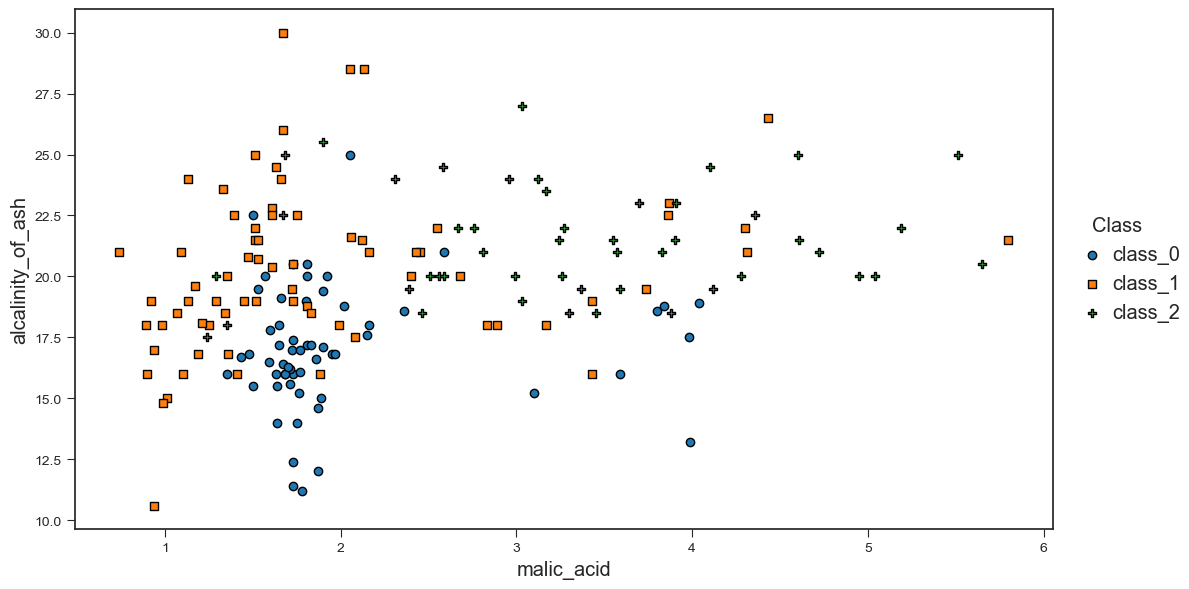

In [24]:
# blank scatter plot can be made if model is not a Classifier
pv = mpc.ProbaVis("-", data["data"], data["target"], [1,3])
pv.plot(contour_on=False)


In [43]:
model.fit(data["data"].iloc[:, [1,3]].values, data["target"])

RandomForestClassifier()

In [51]:
test1 = lambda : model.predict(pv._mesh_entries)
%timeit test1()

59.6 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
test2 = np.vectorize(lambda f0, f1: model.predict(np.array([[f0, f1]])))
%timeit test2(pv._coord_dict["x"],  pv._coord_dict["y"])

1min 25s ± 1.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check the sklearn's own utility module on boundary plotting.

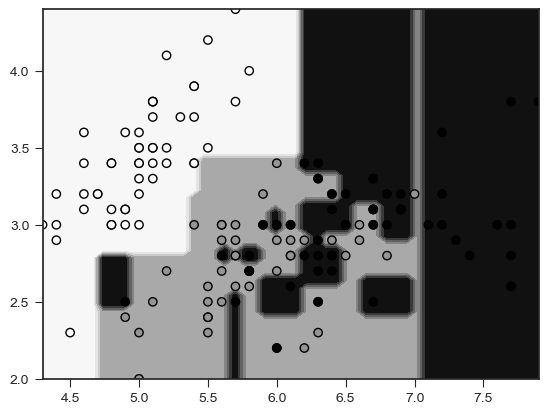

In [20]:
# https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/inspection/_plot/decision_boundary.py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
feature_1, feature_2 = np.meshgrid(
    np.linspace(iris.data[:, 0].min(), iris.data[:, 0].max()),
    np.linspace(iris.data[:, 1].min(), iris.data[:, 1].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
tree = DecisionTreeClassifier().fit(iris.data[:, :2], iris.target)
y_pred = np.reshape(tree.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()

display.ax_.scatter(
    iris.data[:, 0], iris.data[:, 1], c=iris.target, edgecolor="black"
)

plt.show()

## Extras
1.  Output code used to generate the data set and model
2.  Model performance metrics
3.  Contour plot customisation
4.  Help fields for all parameters extracted from documentation
5.  Reset bottom to return to model default params